## Setting up the environment and installing dependencies
Need to install pytorch by running the following cell:

In [ ]:
!pip install -q torch torchvision

Next import some needed modules and define some helper functions

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from pathlib import Path
import tqdm

#Here need to define a path to where the data will be downloaded
data_path = Path("Path")

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda



### Hyper-parameter selection


In [ ]:
# Necessary Hyperparameters 
num_epochs = 10
learning_rate = 0.0001
batch_size = 64
latent_dim = 16 # Choose a value for the size of the latent space

# Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Modify the network's output for visualizing your images
def denorm(x):
    return x

### Data loading


In [ ]:
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change 
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Model Definition
Define the model and output the total number of parameters

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = 512
        self.data_features = 28 * 28
        nf = 28
        self.encoder = nn.Sequential(    
          nn.Conv2d(1, nf, 4, 2,1,  bias=False),
          nn.BatchNorm2d(nf),
          nn.ReLU(),
          nn.Conv2d(nf, nf * 2, 4, 2,1,  bias=False),
          nn.BatchNorm2d(nf*2),
          nn.ReLU(),
          nn.Conv2d(nf * 2, nf * 4, 4, 2,1,  bias=False),
          nn.BatchNorm2d(nf*4),
          nn.ReLU(),
          nn.Conv2d(nf * 4, 512, 3, 1,  bias=False),
          nn.BatchNorm2d(self.hidden_dim),
          nn.ReLU()
          )
        self.mean_network = nn.Linear(self.hidden_dim, self.latent_dim)
        self.logvar_network = nn.Linear(self.hidden_dim, self.latent_dim)
        self.decoder = nn.Sequential( # Convolutional decoder
        # input is Z, going into a convolution
        nn.ConvTranspose2d(16, nf * 8, 4, 1, bias=False),
        nn.BatchNorm2d(nf*8),
        nn.ReLU(),

        nn.ConvTranspose2d(nf * 8, nf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nf*4),
        nn.ReLU(),

        nn.ConvTranspose2d( nf * 4, nf, 2, 2, 1, bias=False),
        nn.BatchNorm2d(nf),
        nn.ReLU(),

        nn.ConvTranspose2d(nf, 1, 4, 2, 1, bias=False),
        nn.Tanh()                             
            )
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))


    def encode(self, x):
        x = self.encoder(x).reshape((x.shape[0], -1))
        
        mean = self.mean_network(x)
        logvar = self.logvar_network(x)
        return mean, logvar
    
    def reparametrize(self, mu, logvar):
        """
        This is the parametrisation trick
        :param mu: mean from the encoder's latent space
        :param logvar: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*logvar) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 

    def decode(self, z):
        z = z.reshape(z.shape[0], z.shape[1],1,1)
        decoding = self.decoder(z)
        reconstruction = torch.sigmoid(decoding)
        return reconstruction

    
    def forward(self, x):
        #Encode the input
        mu, logvar = self.encode(x)
        
        # Get mean and logvar
        # Reparametrise and get latent representation
        z = self.reparametrize(mu, logvar)

        # Decode and reconstruct
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar

model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 1132289
VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(28, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(56, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(112, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (mean_network): Linear(in_features=512, out_features=16, bias=True)
  (logvar_network): Linear(in_features=512, out_features=16, bias=True)
  (decoder): Sequential(
  


## Training the Model

### Defining a Loss

In [ ]:

def loss_function_VAE(recon_x, x, mu, logvar, beta, z):
        loss = nn.BCELoss(reduction='sum')(recon_x, x) # This is reconstruction loss
        
        
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        std = torch.exp(logvar / 2)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # calculate KLD
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        kl = kl.sum()
        
        return loss + beta * kl, loss, kl

model.train()
beta = 1.25
print("Starting training")
# Defining lists for losses

total_losses_train = []
kl_losses_train = []
recon_losses_train = []
total_losses_test = []
kl_losses_test = []
recon_losses_test = []

for epoch in range(num_epochs):
    print(f"Starting {epoch}. epoch")
    epoch_loss = 0.0
    epoch_KD_loss = 0.0
    epoch_recon_loss = 0.0
    with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
        for batch_idx, (data, _) in enumerate(tepoch):   
            #data = None # Need at least one batch/random data with right shape -
                        # This is required to initialize to model properly below
                        # when we save the computational graph for testing (jit.save)
            data = data.to(device)
            optimizer.zero_grad()
            reconstruction, mu, logvar = model(data)
            
            #Sample z from q
            std = torch.exp(logvar / 2)
            q = torch.distributions.Normal(mu, std)
            z = q.rsample()

            #Losses
            loss, loss_recon, loss_kl = loss_function_VAE(reconstruction, data, mu, logvar, beta, z)
            epoch_loss += loss.item()
            epoch_KD_loss += loss_kl.item()
            epoch_recon_loss += loss_recon.item()

            loss.backward()
            optimizer.step()

            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=loss.item()/len(data))
        # Getting average losses for epoch and appending
        avg_ep_total_loss = epoch_loss / (batch_idx*batch_size)
        avg_ep_KLD_loss = epoch_KD_loss / (batch_idx*batch_size)
        avg_ep_recon_loss = epoch_recon_loss / (batch_idx*batch_size)
        total_losses_train.append(avg_ep_total_loss)
        kl_losses_train.append(avg_ep_KLD_loss)
        recon_losses_train.append(avg_ep_recon_loss)
        print("\tEpoch", epoch , "complete!", "\tAverage Loss: ", avg_ep_total_loss)
        
        # Test set evaluation 
        epoch_loss_test = 0.0
        epoch_KD_loss_test = 0.0
        epoch_recon_loss_test = 0.0

        with tqdm.tqdm(loader_test, unit="batch") as tepoch: 
          for batch_idx_test, (data_test, _) in enumerate(tepoch):   
            data_test = data_test.to(device)
            data_test = data_test.view(data_test.size(0), 1, 28, 28)
            reconstruction, mu, logvar = model(data_test)

            #Sample z from q
            std = torch.exp(logvar / 2)
            q = torch.distributions.Normal(mu, std)
            z = q.rsample()

            loss, loss_recon, loss_kl = loss_function_VAE(reconstruction, data_test, mu, logvar, beta, z)

            epoch_loss_test += loss.item()
            epoch_KD_loss_test += loss_kl.item()
            epoch_recon_loss_test += loss_recon.item()

        avg_test_total_loss = epoch_loss_test / (batch_idx_test*batch_size)
        avg_test_KLD_loss = epoch_KD_loss_test / (batch_idx_test*batch_size)
        avg_test_recon_loss = epoch_recon_loss_test / (batch_idx_test*batch_size)
        total_losses_test.append(avg_test_total_loss)
        kl_losses_test.append(avg_test_KLD_loss)
        recon_losses_test.append(avg_test_recon_loss)
        print("\tEpoch", epoch , "complete!", "\tTesting Average Loss: ", avg_test_total_loss)

    # save the model
    save_path = "_"
    if epoch == num_epochs - 1:
        with torch.no_grad():
            torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                save_path)


Starting training
Starting 0. epoch


Epoch 0: 100%|██████████| 938/938 [00:14<00:00, 62.73batch/s, loss=305]


	Epoch 0 complete! 	Average Loss:  303.76373618338636


100%|██████████| 157/157 [00:01<00:00, 95.21batch/s]


	Epoch 0 complete! 	Testing Average Loss:  307.4450535896497
Starting 1. epoch


Epoch 1: 100%|██████████| 938/938 [00:14<00:00, 64.47batch/s, loss=302]


	Epoch 1 complete! 	Average Loss:  303.5570375489323


100%|██████████| 157/157 [00:01<00:00, 95.21batch/s]


	Epoch 1 complete! 	Testing Average Loss:  307.35540688343536
Starting 2. epoch


Epoch 2: 100%|██████████| 938/938 [00:15<00:00, 61.83batch/s, loss=303]


	Epoch 2 complete! 	Average Loss:  303.4081625760301


100%|██████████| 157/157 [00:01<00:00, 87.68batch/s]


	Epoch 2 complete! 	Testing Average Loss:  307.3269472366724
Starting 3. epoch


Epoch 3: 100%|██████████| 938/938 [00:15<00:00, 61.94batch/s, loss=300]


	Epoch 3 complete! 	Average Loss:  303.3029984807001


100%|██████████| 157/157 [00:01<00:00, 94.91batch/s]


	Epoch 3 complete! 	Testing Average Loss:  307.23971674992487
Starting 4. epoch


Epoch 4: 100%|██████████| 938/938 [00:14<00:00, 64.30batch/s, loss=302]


	Epoch 4 complete! 	Average Loss:  303.1563144223794


100%|██████████| 157/157 [00:01<00:00, 93.94batch/s]


	Epoch 4 complete! 	Testing Average Loss:  307.1134547698192
Starting 5. epoch


Epoch 5: 100%|██████████| 938/938 [00:14<00:00, 64.49batch/s, loss=301]


	Epoch 5 complete! 	Average Loss:  303.0258685491637


100%|██████████| 157/157 [00:01<00:00, 95.53batch/s]


	Epoch 5 complete! 	Testing Average Loss:  307.0540844354874
Starting 6. epoch


Epoch 6: 100%|██████████| 938/938 [00:14<00:00, 64.97batch/s, loss=305]


	Epoch 6 complete! 	Average Loss:  302.9183149470082


100%|██████████| 157/157 [00:01<00:00, 95.44batch/s]


	Epoch 6 complete! 	Testing Average Loss:  307.18083997873157
Starting 7. epoch


Epoch 7: 100%|██████████| 938/938 [00:14<00:00, 64.70batch/s, loss=303]


	Epoch 7 complete! 	Average Loss:  302.820295270759


100%|██████████| 157/157 [00:01<00:00, 94.78batch/s]


	Epoch 7 complete! 	Testing Average Loss:  306.91469798943933
Starting 8. epoch


Epoch 8: 100%|██████████| 938/938 [00:14<00:00, 64.63batch/s, loss=304]


	Epoch 8 complete! 	Average Loss:  302.7259911503583


100%|██████████| 157/157 [00:01<00:00, 94.96batch/s]


	Epoch 8 complete! 	Testing Average Loss:  307.03716908968414
Starting 9. epoch


Epoch 9: 100%|██████████| 938/938 [00:14<00:00, 64.61batch/s, loss=305]


	Epoch 9 complete! 	Average Loss:  302.61847985592317


100%|██████████| 157/157 [00:01<00:00, 94.46batch/s]


	Epoch 9 complete! 	Testing Average Loss:  306.8284928248479


## Visualise Samples and Reconstructions

Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
torch.Size([3, 122, 242])
Generated Images
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


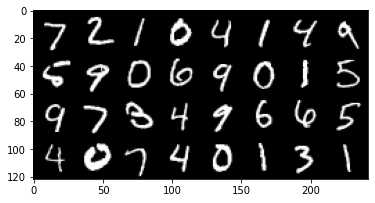

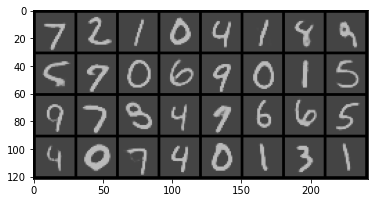

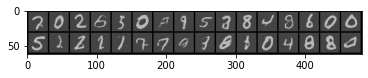

In [ ]:
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)
print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set
    
    fixed_input = fixed_input.to(device)
    fixed_input_flatten = fixed_input.view(fixed_input.size(0), 1, 28, 28)
    recon_batch, _, _ = model(fixed_input_flatten)
    recon_batch = recon_batch.view(fixed_input.shape)

    
    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')  
print('-'*50)
model.eval()
n_samples = 32
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    samples = model.decode(z)
    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(samples)

